## Multivariate Regression

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

import statsmodels.api as sm
import statsmodels.formula.api as smf

from nose.tools import assert_equal, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

In [23]:
filename = '2001.csv'

usecols = (13, 14, 16, 18)
columns = ['AirTime', 'ArrDelay', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

In [27]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "AirTime" vs "Distance" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "AirTime" and "Distance".
    
    Returns
    -------
    A matplotlib
    '''
    ax = sns.regplot(data=df, x='AirTime', y='Distance')
    ax.set(title='Seaborn linear regression',
       xlabel='Air time (min)', xlim=(-100, 700),
       ylabel='Distance (miles)', ylim=(-2000, 6000))
    return ax

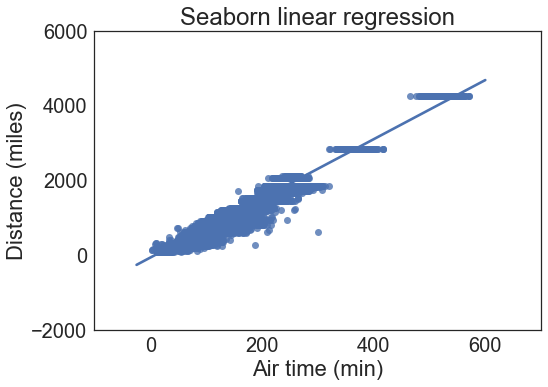

In [28]:
ax1 = plot_seaborn_reg(local)

In [29]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x, y = ax1.collections[0].get_offsets().T
assert_array_equal(x, local["AirTime"])
assert_array_equal(y, local["Distance"])

In [34]:
def get_train_test(df, train_columns, test_columns, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "train_columns" parameter lists the attributes that will be used for training.
    The "test_columns" lists the column that we are trying to predict.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test.split.
    
    Parameters
    ----------
    train_columns: A list of strings
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of 
    '''
    x_train, x_test, y_train, y_test = train_test_split(df[train_columns], df[test_columns], test_size=test_size,random_state=random_state)
    return x_train, x_test, y_train, y_test   

In [35]:
X_train, X_test, y_train, y_test = get_train_test(
    df=local,
    train_columns=['AirTime', 'ArrDelay'],
    test_columns=['Distance'],
    test_size=0.2,
    random_state=check_random_state(0)
)

In [36]:
assert_equal(len(X_train), np.round(len(local) * 0.8))
assert_frame_equal(
    X_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345,  912717, 2456409, 1431043,  721122],
        data={'AirTime': [ 125., 44., 98., 225., 247.], 'ArrDelay': [56., -24., 31., -9., -2.]}
    )
)

assert_equal(len(X_test), np.round(len(local) * 0.2))
assert_frame_equal(
    X_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'AirTime': [98., 224., 231., 230., 81.], 'ArrDelay': [ 14., -22.,  -8.,   0.,   7.]}
    )
)

assert_equal(len(y_train), np.round(len(local) * 0.8))
assert_frame_equal(
    y_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345, 912717, 2456409, 1431043, 721122],
        data={'Distance': [ 802,  235,  733, 1745, 1721]}
    )
)

assert_equal(len(y_test), np.round(len(local) * 0.2))
assert_frame_equal(
    y_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'Distance': [606, 1781, 1846, 1721, 594]}
    )
)

In [98]:
def get_statsmodels_reg(df_fit, X_predict):
    '''
    Trains OLS on the columns in "df_fit" and makes a prediction for "X_predict".
    Returns the predicted `DepDelay` values.
    
    Parameters
    ----------
    df_fit: A pandas.DataFrame. Should have "AirTime", "ArrDelay", and "Distance" columns.
    X_predict: A pandas.DataFrame. Should have "AirTime" and "ArrDelay" columns.
    
    Returns
    -------
    A numpy array
    '''
    model = sklearn.linear_model.LinearRegression()
    model.fit(df_fit.iloc[:,[0,1]],df_fit.iloc[:,[2]])
    y_pred = model.predict(X_predict)
    return y_pred.flatten()

In [99]:
df_train = pd.DataFrame({
    "AirTime": X_train["AirTime"].values,
    "ArrDelay": X_train["ArrDelay"].values,
    "Distance": y_train["Distance"].values})

X_pred = pd.DataFrame({
    'AirTime': np.linspace(X_test['AirTime'].min(), X_test['AirTime'].max(), 10),
    'ArrDelay': np.linspace(X_test['ArrDelay'].min(), X_test['ArrDelay'].max(), 10)
    })

y_pred = get_statsmodels_reg(df_train, X_pred)

In [100]:
assert_array_almost_equal(
    y_pred,
    np.array([  -10.24755291,   432.77802136,   875.80359563,  1318.8291699 ,
        1761.85474417,  2204.88031843,  2647.9058927 ,  3090.93146697,
        3533.95704124,  3976.9826155 ])
    )


In [114]:
def plot_statsmodels_reg(df_test, df_pred):
    '''
    Plots the follwoing:
    1. A scatter plot of the "AirTime" column of "df_test" on the x-axis
       and the "Distance" column of "df_test" on the y-axis,
    2. A straight line (multivariate linear regression model) of the
       "AirTime" column of "df_pred" on the x-axis and the "Distance"
       column of "df_pred" on the y-axis.
              
    Parameters
    ----------
    df_test: A pandas.DataFrame
    df_pred: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    ax = sns.regplot(x=df_test['AirTime'], y=df_test['Distance'],fit_reg=False)
    plt.plot(df_pred['AirTime'], df_pred['Distance'], color='red')
    ax.set(title='statsmodels regression',
       xlabel='Air time (minutes)', xlim=(-100, 600),
       ylabel='Distance (miles)', ylim=(-1000, 5000))
    return ax

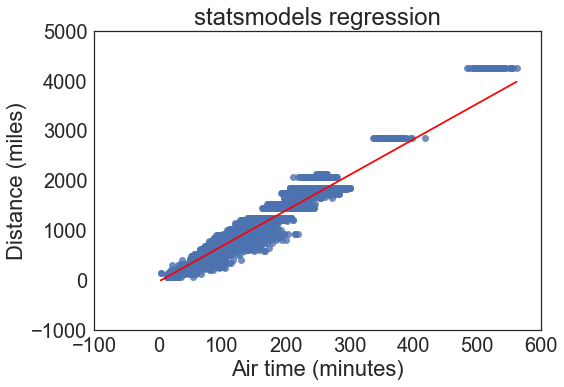

In [115]:
df_test = pd.DataFrame({
    'AirTime': X_test['AirTime'].values,
    'Distance': y_test['Distance'].values
    })

df_pred = pd.DataFrame({
    'AirTime': X_pred['AirTime'].values,
    'Distance': y_pred
    })

ax2 = plot_statsmodels_reg(df_test, df_pred)

In [116]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, df_test["AirTime"])
assert_array_equal(y_scatter, df_test["Distance"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, df_pred["AirTime"])
assert_array_almost_equal(y_line, y_pred)

## Regularization

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
    
from nose.tools import assert_equal, assert_is_not
from numpy.testing import assert_array_equal, assert_almost_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

In [3]:
filename = '2001.csv'

usecols = (5, 15, 16)
columns = ['CRSDepTime', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

In [4]:
def get_hourly(df):
    return df.groupby(pd.cut(df['CRSDepTime'], np.arange(0, 2400, 100))).mean().dropna()

hourly = get_hourly(local)
print(hourly)

               CRSDepTime   DepDelay
CRSDepTime                          
(500, 600]     595.588556   1.160309
(600, 700]     649.187489   1.922079
(700, 800]     740.461376   4.788713
(800, 900]     838.512038   6.073624
(900, 1000]    941.117287   7.533417
(1000, 1100]  1029.092318   7.959812
(1100, 1200]  1143.347120   8.945600
(1200, 1300]  1237.310490   9.465208
(1300, 1400]  1330.703802  10.080120
(1400, 1500]  1444.372347  12.928801
(1500, 1600]  1528.276364  14.855922
(1600, 1700]  1647.206659  15.155163
(1700, 1800]  1737.540096  16.915603
(1800, 1900]  1836.121684  18.688567
(1900, 2000]  1936.516002  20.037355
(2000, 2100]  2040.102539  18.882328
(2100, 2200]  2131.162948  18.011156
(2200, 2300]  2210.144461  13.627994


In [130]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "DepDelay" vs "CRSDepTime" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "CRSDepTime" and "DepDelay".
    
    Returns
    -------
    A matplotlib Axes object
    '''
    ax = sns.regplot(df['CRSDepTime'], df['DepDelay'], fit_reg=True)
    ax.set(title='Seaborn regression',
           xlabel='Scheduled departure time (local, hhmm)', 
           xlim=(500,2500),
           ylabel='Departure delay (min)', ylim=(-5,30))
    return ax

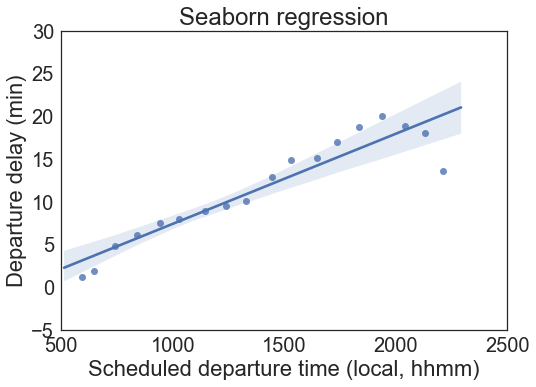

In [131]:
ax1 = plot_seaborn_reg(hourly)

In [132]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "CRSDepTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "DepDelay", msg="Change the y-axis label to something more descriptive.")
    
x_axis, y_axis = ax1.collections[0].get_offsets().T
assert_array_equal(x_axis, hourly["CRSDepTime"])
assert_array_equal(y_axis, hourly["DepDelay"])

In [12]:
def fit_reg_poly(df, degree, alpha=1.0,  max_iter=1000):
    '''
    Fits a ridge regression model on "CRSDepTime" to predict "DepDelay".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"
    
    Returns
    -------
    A tuple of (sklearn.Pipeline object, numpy.ndarray)
    '''
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha,max_iter=max_iter))
    est.fit(df[['CRSDepTime']], df['DepDelay'])
    prediction=est.predict(df[['CRSDepTime']])[:, np.newaxis]
    return est, prediction

In [13]:
est1, pred1 = fit_reg_poly(hourly, 1, alpha=0.1)
est1_params = est1.get_params()
answer1 = np.array([[  3.12076375],
       [  3.68635785],
       [  4.64951082],
       [  5.68417463],
       [  6.76689997],
       [  7.6952423 ],
       [  8.90089767],
       [  9.89243099],
       [ 10.87794885],
       [ 12.07741784],
       [ 12.96280146],
       [ 14.21779423],
       [ 15.17102325],
       [ 16.21128956],
       [ 17.27068441],
       [ 18.36376465],
       [ 19.32466493],
       [ 20.15810461]])
assert_equal(est1_params['polynomialfeatures__degree'], 1)
assert_equal(est1_params['lasso__alpha'], 0.1)
assert_array_almost_equal(pred1, answer1)

est2, pred2 = fit_reg_poly(hourly, 2, alpha=1)
est2_params = est2.get_params()
answer2 = np.array([[  0.9892996 ],
       [  2.02149715],
       [  3.70465785],
       [  5.40809664],
       [  7.07455156],
       [  8.40883505],
       [ 10.01138571],
       [ 11.21898759],
       [ 12.32058151],
       [ 13.52858917],
       [ 14.3267865 ],
       [ 15.32215064],
       [ 15.97156988],
       [ 16.57525611],
       [ 17.07738524],
       [ 17.47631674],
       [ 17.72704719],
       [ 17.86877765]])
assert_equal(est2_params['polynomialfeatures__degree'], 2)
assert_equal(est2_params['lasso__alpha'], 1)
assert_array_almost_equal(pred2, answer2)

In [14]:
def find_mse(df, degree):
    '''
    Computes mean squared error of a Ridge Regression model on "df".
    Uses the "fit_reg_poly()" function.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"

    Returns
    -------
    A float.
    '''
    pred = fit_reg_poly(df, degree, alpha=1.0)[1]
    mse=mean_squared_error(df['DepDelay'][:, np.newaxis],pred)
    return mse

In [15]:
degrees = list()
for i in range(1, 15):
    degrees.append(find_mse(hourly, i))

best_degree = np.argmin(degrees) + 1 # because degree = 1 corresponds to arg = 0
print('The best model is a polynomial of degree {}.'.format(best_degree))

The best model is a polynomial of degree 14.


In [16]:
assert_almost_equal(find_mse(hourly, 1), 4.18137098)
assert_almost_equal(find_mse(hourly, 2), 2.56271490)
assert_almost_equal(find_mse(hourly, 3), 2.05451124)
assert_almost_equal(find_mse(hourly, 4), 1.54515768)
assert_almost_equal(find_mse(hourly, 5), 1.30647284)

In [26]:
def plot_reg_ploy(df, degree):
    '''
    Plots the follwoing:
    1. A scatter plot of the "CRSDepTime" column of "df" on the x-axis
       and the "DepDelay" column of "df" on the y-axis,
    2. A line that represents a polynomial of degree "degree".
              
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    ax = sns.regplot(df["CRSDepTime"], df['DepDelay'],fit_reg=False)
    est,pred=fit_reg_poly(hourly, degree, alpha=1.0)
    plt.plot(df["CRSDepTime"],pred,c='g')
    ax.set(title='Regularized polynomial regression',
           xlabel='Scheduled departure time (hhmm)', xlim=(500, 2500),
           ylabel='Departure delay (mins)', ylim=(0, 25))
    return ax

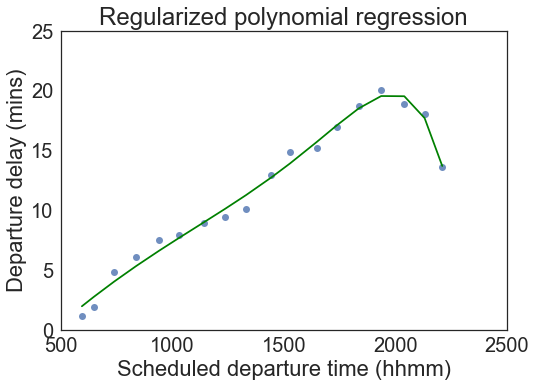

In [27]:
ax2 = plot_reg_ploy(hourly, best_degree)

In [28]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, hourly["CRSDepTime"])
assert_array_equal(y_scatter, hourly["DepDelay"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, hourly["CRSDepTime"])
assert_array_almost_equal(y_line[:, np.newaxis], fit_reg_poly(hourly, 14)[1])

## Logistic Regression

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
    
import statsmodels
import statsmodels.api as sm

from nose.tools import assert_equal
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

In [3]:
filename = '2001.csv'

usecols = (3, 8, 15, 17)
columns = ['DayOfWeek', 'UniqueCarrier', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns).dropna()

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

In [32]:
print(local.head())

      DayOfWeek UniqueCarrier  DepDelay Origin
1855          2            US      -1.0    ORD
1856          3            US      -4.0    ORD
1857          4            US      -3.0    ORD
1858          5            US      -3.0    ORD
1859          6            US      -4.0    ORD


In [4]:
def convert_to_binary(df, column, cutoff):
    '''
    Converts one column in Pandas.DataFrame "df" into binary
    as a new column, and returns the new DataFrame ("df" plus new binary column).
    Note that "df" should NOT be altered.
    
    The returned DataFrame has one more column than "df".
    The name of this column is in the form "column_binary".
    For example, if "column" is "DepDelay", the name of the extra column
    in the returned DataFrame is "DepDelay_binary".
    
    We assume that df[column] contains only ints or floats.
    If df[column] < cutoff, df[column_binary] is 0.
    If df[column] >= cutoff, df[column_binary] is 1.
    
    Parameters
    ----------
    df: A Pandas.DataFrame.
    column: A string.
    cutoff: An int.
    
    Returns
    -------
    A Pandas.DataFrame.
    '''
    new=df.copy()
    new[column+'_binary']=(new[column] >= cutoff).astype(int)
    return new

In [5]:
local = convert_to_binary(local, 'DepDelay', 5)

In [62]:
print(local.tail(10))

         DayOfWeek UniqueCarrier  DepDelay Origin  DepDelay_binary
5960735          6            DL       4.0    ORD                0
5960736          7            DL       7.0    ORD                1
5960737          1            DL      -2.0    ORD                0
5960738          2            DL      -3.0    ORD                0
5960739          3            DL       0.0    ORD                0
5960740          4            DL      58.0    ORD                1
5960741          5            DL       1.0    ORD                0
5960742          6            DL       0.0    ORD                0
5960743          7            DL      -8.0    ORD                0
5960744          1            DL      -3.0    ORD                0


In [6]:
df0 = pd.DataFrame({
    'a': list(range(-5, 5)),
    'b': list(range(10))
    })

test1 = convert_to_binary(df0, 'a', 0)
answer1 = df0.join(pd.DataFrame({'a_binary': [0] * 5 + [1] * 5}))
assert_frame_equal(test1, answer1)

test2 = convert_to_binary(df0, 'b', 4)
answer2 = df0.join(pd.DataFrame({'b_binary': [0] * 4 + [1] * 6}))
assert_frame_equal(test2, answer2)

In [31]:
def convert_to_dummy(df, dummy_columns, keep_columns):
    '''
    Transforms categorical variables of dummy_columns into binary indicator variables.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    dummy_columns: A list of strings. Columns of df that are converted to dummies.
    keep_columns: A list of strings. Columns of df that are kept in the result.
    
    
    Returns
    -------
    A pandas.DataFrame
    '''
    new=df[keep_columns+dummy_columns]
    new=pd.get_dummies(new,columns=dummy_columns)
    return new

In [32]:
data = convert_to_dummy(local, dummy_columns=['DayOfWeek', 'UniqueCarrier'], keep_columns=['DepDelay_binary'])
print(data.head())

      DepDelay_binary  DayOfWeek_1  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
1855                0            0            1            0            0   
1856                0            0            0            1            0   
1857                0            0            0            0            1   
1858                0            0            0            0            0   
1859                0            0            0            0            0   

      DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  UniqueCarrier_AA  \
1855            0            0            0                 0   
1856            0            0            0                 0   
1857            0            0            0                 0   
1858            1            0            0                 0   
1859            0            1            0                 0   

      UniqueCarrier_AS  UniqueCarrier_CO  UniqueCarrier_DL  UniqueCarrier_HP  \
1855                 0                 0                 0        

In [50]:
def add_intercept(df):
    '''
    Appends to "df" an "Intercept" column whose values are all 1.0.
    Note that "df" should NOT be altered.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    new=df.copy()
    new['Intercept']=1
    return new

In [51]:
data = add_intercept(data)
print(data['Intercept'].head())

1855    1
1856    1
1857    1
1858    1
1859    1
Name: Intercept, dtype: int64


In [52]:
df0 = pd.DataFrame({'a': [c for c in 'abcde']})

test1 = add_intercept(df0)
answer1 = df0.join(pd.DataFrame({'Intercept': [1] * 5}))

assert_frame_equal(test1, answer1)

In [62]:
def fit_logitistic(df, train_columns, test_column):
    '''
    Fits a logistic regression model on "train_columns" to predict "test_column".
    
    The function returns a tuple of (model ,result).
    "model" is an instance of Logit(). "result" is the result of Logit.fit() method.
    
    Parameters
    ----------
    train_columns: A list of strings
    test_column: A string
    
    Returns
    -------
    A tuple of (model, result)
    model: An object of type statsmodels.discrete.discrete_model.Logit
    result: An object of type statsmodels.discrete.discrete_model.BinaryResultsWrapper
    '''
    logit = sm.Logit(data[test_column], data[train_columns])
    result = logit.fit()
    return logit,result

In [63]:
train_columns = [
        'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
        'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
        'UniqueCarrier_AS', 'UniqueCarrier_CO', 'UniqueCarrier_DL',
        'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW',
        'UniqueCarrier_TW', 'UniqueCarrier_UA', 'UniqueCarrier_US',
        'Intercept'
        ]

model, result = fit_logitistic(data, train_columns=train_columns, test_column='DepDelay_binary')

Optimization terminated successfully.
         Current function value: 0.589094
         Iterations 5


In [64]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        DepDelay_binary   No. Observations:               321227
Model:                          Logit   Df Residuals:                   321211
Method:                           MLE   Df Model:                           15
Date:                Wed, 19 Jul 2017   Pseudo R-squ.:                0.005735
Time:                        18:33:49   Log-Likelihood:            -1.8923e+05
converged:                       True   LL-Null:                   -1.9032e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
DayOfWeek_2         -0.1574      0.015    -10.479      0.000      -0.187      -0.128
DayOfWeek_3          0.0164      0.015      1.113      0.266      -0.012       0.045
DayOfWeek_4          0.2148 

In [65]:
assert_equal(isinstance(model, statsmodels.discrete.discrete_model.Logit), True)
assert_equal(isinstance(result, statsmodels.discrete.discrete_model.BinaryResultsWrapper), True)

assert_equal(model.exog_names, train_columns)
assert_equal(model.endog_names, 'DepDelay_binary')

assert_array_equal(model.exog, data[train_columns].values)
assert_array_equal(model.endog, data['DepDelay_binary'].values)

test_conf_int = result.conf_int()
answer_conf_int = pd.DataFrame(
    index=train_columns,
    data={
        0: np.array([
            -0.18681953, -0.01247828,  0.18652782,  0.17760447, -0.00675086,
            0.07974488, -0.6227236 , -0.06873794,  0.50352299,  0.78551841,
            0.06694527,  0.21153022,  0.30383117,  0.17150234,  0.20497387,
            -1.166157  ]),
        1: np.array([
            -0.12794527,  0.04524193,  0.24298324,  0.23413964,  0.05254801,
            0.13724129, -0.09649653,  0.04848345,  0.59783265,  0.93824414,
            0.11429806,  0.30780938,  0.44591082,  0.20879553,  0.30969833,
            -1.11899193])
        }
    )
assert_frame_equal(test_conf_int, answer_conf_int)

In [66]:
print(local.groupby('DayOfWeek').mean().sort_values(by='DepDelay', ascending=False))

            DepDelay  DepDelay_binary
DayOfWeek                            
4          11.419251         0.311135
5          11.306297         0.309324
7          10.244282         0.288786
3           9.962156         0.270426
1           9.336543         0.267238
6           9.015426         0.271879
2           7.230843         0.237644


In [67]:
print(local.groupby('UniqueCarrier').mean().sort_values(by='DepDelay', ascending=False))

               DayOfWeek   DepDelay  DepDelay_binary
UniqueCarrier                                       
HP              3.973684  18.245494         0.444845
DL              3.972141  11.719453         0.370235
UA              3.953615  11.027225         0.291036
TW              3.881535  10.183537         0.330645
NW              3.827438   9.445194         0.305562
CO              3.788118   9.215042         0.251857
US              3.922626   9.207263         0.305168
MQ              3.937944   9.099671         0.270765
AA              3.957042   8.298827         0.253498
AS              3.991667   4.791667         0.191667
